# Harnessing Machine Learning For Interpersonal Physical Alignment

### Based on a research paper by Dr. Roi Yozevitch, Dr. Hila Gvirts, Dr. Ornit Apelboim, and Dr. Elhanan Mishraky.
##### This work presents a novel way to determine interpersonal physical synchrony state by inspecting hands’ postures obtained from a unique 3D depth camera device named Leap-Motion Controller.

Alon Firestein

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [24]:
def combine_rows(df):
    cols = df.columns
    df = df.groupby(df.index//5)[cols].apply(lambda x: pd.DataFrame(x.values)).unstack().reset_index()
    df.columns = df.columns.droplevel()
    new_cols = ["index"]
    for col in cols:
        for i in range(5):
            new_cols.append(col+str(i)) 
        
    df.columns = new_cols
    unimportant_features = ["index"]
    features = ["Time","Frame ID","state","Hand Type","# hands"]
    for feat in features:
        for i in new_cols:
            if feat in i:
                df[feat] = df[i]
                unimportant_features.append(i)
    df = df.drop(unimportant_features,axis=1)
    num_features = [x for x in df.columns if x not in features]
    df[num_features] = df[num_features].apply(pd.to_numeric)
    return df

In [25]:
def define_state(filename):
    if 'Spontan' in filename:
        state = 1
    elif 'Sync' in filename:
        state = 2
    else:
        state = 3
    return state

def handle_right_hand_file(df):
    alone_right = pd.read_csv(r"Unity Data/HandRight.csv",index_col=None, header=0)
    alone_right.rename(columns=lambda x: x.strip(), inplace=True)
    alone_right["state"] = 3
    return df

In [26]:
def combine_datasets(path):
    all_files = glob.glob(path)
    lst = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        df.rename(columns=lambda x: x.strip(), inplace=True)        
        df['state'] = define_state(filename)
        start_time = df["Time"].min()
        df = df[df["Time"]>start_time+7]
        df = combine_rows(df)
        df["Time"] = df["Time"].astype("float")
        df = df[df['state'].notna()]
        df["state"] = df["state"].astype("int")
        lst.append(df)
        
    df = pd.concat(lst, axis=0, ignore_index=True)
    df = handle_right_hand_file(df)
    
    return df

In [27]:
df = combine_datasets(r"Unity Data/Training/*/*.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Position X0,Position X1,Position X2,Position X3,Position X4,Position Y0,Position Y1,Position Y2,Position Y3,Position Y4,...,Pinch Strength0,Pinch Strength1,Pinch Strength2,Pinch Strength3,Pinch Strength4,Time,Frame ID,state,Hand Type,# hands
0,-107.2023,200.69760,-112.8274,202.13650,-117.6233,194.5495,316.9962,199.1187,319.0723,201.9223,...,0.0,1.000000,0.000000,1.000000,0.000000,477.5815,144870,2,left,2
1,156.2055,-97.04962,156.4148,-97.17081,156.5472,164.9383,119.6590,163.8100,117.7113,163.7894,...,0.0,0.000000,0.000000,0.000000,0.000000,394.2714,46005,1,right,2
2,104.7304,-115.83640,105.6461,-115.66270,106.4900,154.9454,167.1620,157.9461,166.3596,160.9670,...,0.0,0.000000,0.000000,0.000000,0.000000,324.2692,37909,2,right,2
3,145.1910,-122.66820,145.6862,-124.99410,145.7264,222.0476,214.0030,223.6624,216.0111,223.3507,...,1.0,0.973376,0.904589,0.991065,0.581994,427.4875,49827,1,right,2
4,-141.5070,-140.38220,-140.6613,-142.22320,-142.7181,237.7053,234.0647,231.0223,227.9846,224.6611,...,0.0,0.000000,0.000000,0.000000,0.000000,276.4540,121697,3,left,1


In [28]:
y = df["state"]
x = df.drop(["Hand Type","# hands","Time", "Frame ID"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# KNN:

In [29]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
print("-----------------K-nearest neighbors Report---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix: \n", knn_cm)
print(metrics.classification_report(y_test, y_pred_knn))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(knn,x_train,y_train,cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")

-----------------K-nearest neighbors Report---------------
F1 score: 0.8935819334095836
Accuracy score: 0.8937963757508455
Confusion matrix: 
 [[6689 1302   23]
 [ 747 7291   16]
 [   9    7 3727]]
              precision    recall  f1-score   support

           1       0.90      0.83      0.87      8014
           2       0.85      0.91      0.88      8054
           3       0.99      1.00      0.99      3743

    accuracy                           0.89     19811
   macro avg       0.91      0.91      0.91     19811
weighted avg       0.90      0.89      0.89     19811

Cross Validation Scores: [0.88440025 0.88562904 0.88463451 0.88973148 0.88314272]
Cross Validation Scores Mean: 0.8855075982036649 



Text(0.5, 1.08, 'KNN Prediction Heatmap')

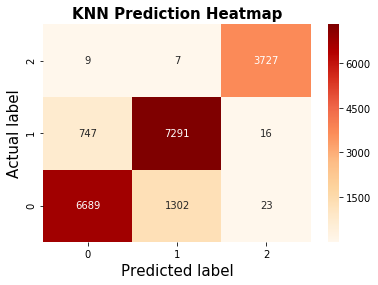

In [53]:
ax=sns.heatmap(confusion_matrix(y_test, y_pred_knn), cmap="OrRd",annot=True, fmt="d")
ax.set(ylim=(0, 3))
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
plt.title('KNN Prediction Heatmap', size = 15, y=1.08, fontweight="bold")

# Random Forest:

In [116]:
rf=RandomForestClassifier(n_estimators = 100, random_state = 123, max_depth=2)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
rf_f1 = metrics.f1_score(y_test, y_pred_rf, average= "weighted")
rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print("--------------------Random Forest------------------")
print("F1 score: {}".format(rf_f1))
print("Accuracy score: {}".format(rf_accuracy))
print("Confusion matrix: \n", rf_cm)
print(metrics.classification_report(y_test, y_pred_rf))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(rf,x_train,y_train,cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")

--------------------Random Forest------------------
F1 score: 0.950835749708399
Accuracy score: 0.9509363484932614
Confusion matrix: 
 [[7946  114   29]
 [ 736 7181   26]
 [  15   52 3712]]
              precision    recall  f1-score   support

           1       0.91      0.98      0.95      8089
           2       0.98      0.90      0.94      7943
           3       0.99      0.98      0.98      3779

    accuracy                           0.95     19811
   macro avg       0.96      0.96      0.96     19811
weighted avg       0.95      0.95      0.95     19811

Cross Validation Scores: [0.96482287 0.96034311 0.95723521 0.96034311 0.9633267 ]
Cross Validation Scores Mean: 0.961214201320951 



# Gradient Boosting Classifier:

In [142]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=12)
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(x_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(x_test, y_test)),"\n")

Learning rate:  0.05
Accuracy score (training): 0.801
Accuracy score (testing): 0.778 

Learning rate:  0.075
Accuracy score (training): 0.856
Accuracy score (testing): 0.829 

Learning rate:  0.1
Accuracy score (training): 0.880
Accuracy score (testing): 0.856 

Learning rate:  0.25
Accuracy score (training): 0.928
Accuracy score (testing): 0.900 

Learning rate:  0.5
Accuracy score (training): 0.954
Accuracy score (testing): 0.940 

Learning rate:  0.75
Accuracy score (training): 0.983
Accuracy score (testing): 0.969 

Learning rate:  1
Accuracy score (training): 0.990
Accuracy score (testing): 0.977 



In [145]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(x_train, y_train)
y_pred_gb_clf2 = gb_clf2.predict(x_test)
gb_clf2_f1 = metrics.f1_score(y_test, y_pred_gb_clf2, average= "weighted")
gb_clf2_accuracy = metrics.accuracy_score(y_test, y_pred_gb_clf2)
gb_clf2_cm = metrics.confusion_matrix(y_test, y_pred_gb_clf2)
print("--------------------Gradient Boosting------------------")
print("F1 score: {}".format(gb_clf2_f1))
print("Accuracy score: {}".format(gb_clf2_accuracy))
print("Confusion matrix: \n", gb_clf2_cm)
print(metrics.classification_report(y_test, y_pred_gb_clf2))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(gb_clf2,x_train,y_train,cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")

--------------------Gradient Boosting------------------
F1 score: 0.9772066378565647
Accuracy score: 0.9771962616822429
Confusion matrix: 
 [[1048   35    1]
 [  17 1056    3]
 [   1    4  510]]
              precision    recall  f1-score   support

           1       0.98      0.97      0.97      1084
           2       0.96      0.98      0.97      1076
           3       0.99      0.99      0.99       515

    accuracy                           0.98      2675
   macro avg       0.98      0.98      0.98      2675
weighted avg       0.98      0.98      0.98      2675

Cross Validation Scores: [0.98526703 0.97697974 0.97790055 0.97882136 0.97695853]
Cross Validation Scores Mean: 0.9791854435589956 



# Linear Support Vector Classification:

In [209]:
svc_clf = make_pipeline(StandardScaler(),LinearSVC(random_state=42))
svc_clf.fit(x, y)
y_pred_svc_clf = svc_clf.predict(x_test)
svc_clf_f1 = metrics.f1_score(y_test, y_pred_svc_clf, average= "weighted")
svc_clf_accuracy = metrics.accuracy_score(y_test, y_pred_svc_clf)
svc_clf_cm = metrics.confusion_matrix(y_test, y_pred_svc_clf)
print("---------------Linear SVC-------------")
print("F1 score: {}".format(svc_clf_f1))
print("Accuracy score: {}".format(svc_clf_accuracy))
print("Confusion matrix: \n", svc_clf_cm)
print(metrics.classification_report(y_test, y_pred_svc_clf))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(svc_clf,x_train,y_train,cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")

---------------Linear SVC-------------
F1 score: 0.9914137749626374
Accuracy score: 0.991418908687093
Confusion matrix: 
 [[8045   44    0]
 [   0 7924   19]
 [   0  107 3672]]
              precision    recall  f1-score   support

           1       1.00      0.99      1.00      8089
           2       0.98      1.00      0.99      7943
           3       0.99      0.97      0.98      3779

    accuracy                           0.99     19811
   macro avg       0.99      0.99      0.99     19811
weighted avg       0.99      0.99      0.99     19811

Cross Validation Scores: [0.99042884 0.99254102 0.9908006  0.99154649 0.99316261]
Cross Validation Scores Mean: 0.9916959117643515 



# Logistic Regression:

In [222]:
lr = LogisticRegression(random_state=0)
lr.fit(x, y)
y_pred_lr = lr.predict(x_test)
lr_f1 = metrics.f1_score(y_test, y_pred_lr, average= "weighted")
lr_accuracy = metrics.accuracy_score(y_test, y_pred_lr)
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
print("-------------Logistic Regression-------------")
print("F1 score: {}".format(lr_f1))
print("Accuracy score: {}".format(lr_accuracy))
print("Confusion matrix: \n", lr_cm)
print(metrics.classification_report(y_test, y_pred_lr))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(lr, x_train, y_train, cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")

-------------Logistic Regression-------------
F1 score: 0.9097067550670614
Accuracy score: 0.9097471101913078
Confusion matrix: 
 [[7515  538   36]
 [1065 6845   33]
 [  40   76 3663]]
              precision    recall  f1-score   support

           1       0.87      0.93      0.90      8089
           2       0.92      0.86      0.89      7943
           3       0.98      0.97      0.98      3779

    accuracy                           0.91     19811
   macro avg       0.92      0.92      0.92     19811
weighted avg       0.91      0.91      0.91     19811

Cross Validation Scores: [0.91746426 0.93920935 0.94567379 0.93050721 0.93983093]
Cross Validation Scores Mean: 0.9345371092923044 



# Validation:

In [229]:
test_df = combine_datasets(r"Unity Data/Validation/*/*.csv")
test_df = test_df.dropna()
y = test_df["state"]
x = test_df.drop(["Frame ID","state","Hand Type","# hands"], axis=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=93)

In [192]:
print("K-nearest neighbors:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_score(knn, x, y, cv=kfold,n_jobs=-1)), np.std(cross_val_score(knn, x, y, cv=kfold,n_jobs=-1))))

K-nearest neighbors:
0.96% (+/- 0.00%)


In [193]:
print("Random Forest:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_score(rf, x, y, cv=kfold,n_jobs=-1)), np.std(cross_val_score(rf, x, y, cv=kfold,n_jobs=-1))))

Random Forest:
0.80% (+/- 0.01%)


In [194]:
print("Gradient Boosting:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_score(gb_clf2, x, y, cv=kfold,n_jobs=-1)), np.std(cross_val_score(gb_clf2, x, y, cv=kfold,n_jobs=-1))))

Gradient Boosting:
0.93% (+/- 0.01%)


In [210]:
print("Linear SVC:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_score(svc_clf, x, y, cv=kfold,n_jobs=-1)), np.std(cross_val_score(svc_clf, x, y, cv=kfold,n_jobs=-1))))

Linear SVC:
0.99% (+/- 0.00%)


In [231]:
print("Logistic Regression:")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_score(lr, x, y, cv=kfold)), np.std(cross_val_score(lr, x, y, cv=kfold))))

Logistic Regression:
0.83% (+/- 0.00%)


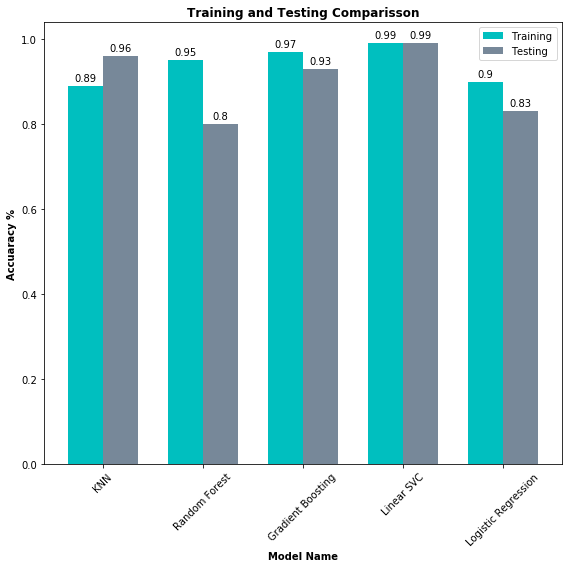

In [54]:
labels = ['KNN', 'Random Forest', 'Gradient Boosting','Linear SVC', 'Logistic Regression']
training_scores = [0.89, 0.95, 0.97, 0.99, 0.90]
testing_scores = [0.96, 0.80, 0.93, 0.99, 0.83]

x = np.arange(len(labels))
width = 0.35  
fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - width/2, training_scores, width, color='c')
rects2 = ax.bar(x + width/2, testing_scores, width, color='lightslategrey')
ax.set_title('Training and Testing Comparisson', fontweight="bold")
ax.set_xlabel('Model Name', fontweight="bold")
ax.set_ylabel('Accuaracy %', fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend(['Training', 'Testing'], loc='best')
plt.xticks(rotation=45)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()